In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

In [145]:
data = pd.read_csv("data/unique_result.csv")
data = pd.DataFrame.transpose(data)
data = data.iloc[1:10][0]
data

prawo cywilne            ['remontowobudowlane', 'przedawnieniu', 'weksl...
prawo administracyjne    ['bankowych', 'budowlane', 'wywieszenie', 'nie...
prawo farmaceutyczne     ['dostępny', 'terenie', 'gifu', 'wzoru', 'iwyc...
prawo pracy              ['odprawy', 'zaległy', 'pracownicę', 'równoważ...
prawo medyczne           ['wyglądają', 'wyraził', 'ponad', 'najniższego...
prawo karne              ['płyty', 'pieniądze', 'dobrowolnej', 'zapobie...
prawo miädzynarodowe     ['udzielać', 'rękawice', 'już', 'bezpieczeństw...
prawo podatkowe          ['kwoty', 'leki', 'wstecz', 'fakturze', 'nacze...
prawo konstytucyjne       ['wyjść', 'powrocie', 'konstytucją', 'przepisy']
Name: 0, dtype: object

In [107]:
# data = []
# f = open('data/result-list.txt', 'r',encoding='utf-8')
# if f.mode=='r':
#     data= f.read()

Get Glove (https://nlp.stanford.edu/projects/glove/)

In [117]:
from gensim.models import KeyedVectors
# def gimme_glove():
#     with open('data/glove_100_3_polish.txt', encoding='utf-8') as glove_raw:
#         for line in glove_raw.readlines():
#             splitted = line.split(' ')
#             yield splitted[0], np.array(splitted[1:], dtype=float)
# glove = {w: x for w, x in gimme_glove()}

glove = KeyedVectors.load_word2vec_format("data/glove_100_3_polish.txt")

def closest_word(in_vector, top_n=1):
    vectors = glove.values()
    idx = np.argsort([np.linalg.norm(vec-in_vector) for vec in vectors])
    return [glove.keys()[i] for i in idx[:top_n]]

In [116]:
def vectorize_tokens(tokens):
    words = [w for w in tokens if w is not None and w != ' ']
    return np.array([glove.get_vector(w) for w in words])

In [132]:
colors = OrderedDict({
    'prawo cywilne':'orange',
    'prawo administracyjne':'red',
    'prawo farmaceutyczne':'blue',
    'prawo pracy':'green',
    'prawo medyczne':'cyan',
    'prawo karne':'brown',
    'prawo miädzynarodowe':'black',
    'prawo podatkowe':'purple',
    'prawo konstytucyjne':'grey'
})
speechPartNames = list(colors.keys())
W = [vectorize_tokens(tokenized).mean(axis=0) for tokenized in data]
W = np.array(W)
W

array([[-0.02240876,  0.00103112,  0.30629843, ..., -0.33404028,
         0.24884836, -0.10096144],
       [-0.01469646, -0.02268776,  0.3137705 , ..., -0.33499673,
         0.2711538 , -0.10704955],
       [-0.01873532, -0.02716664,  0.30500734, ..., -0.30655718,
         0.27380675, -0.08595166],
       ...,
       [-0.03599441,  0.03761097,  0.35449794, ..., -0.27408904,
         0.32724217, -0.13635813],
       [-0.02999772,  0.01076369,  0.31258196, ..., -0.34743702,
         0.22806954, -0.11999498],
       [-0.22422324,  0.0524814 ,  0.23943682, ..., -0.2932328 ,
         0.28405055, -0.1285887 ]], dtype=float32)

In [122]:
from minisom import MiniSom

In [173]:
map_dim = 16
som = MiniSom(map_dim, map_dim, 100, sigma=1.0, random_seed=1)
# som.random_weights_init(W)
som.train_batch(W, num_iteration=len(W)*100, verbose=True)

 [ 1100 / 1100 ] 100% - 0:00:00 left 
 quantization error: 0.000559240161633507


In [174]:
from string import punctuation
import stop_words
stopwords = stop_words.get_stop_words('polish')
def clearListFromUselessWords(words: list):
    for sign in punctuation:
        if sign in words:
            words.remove(sign)
    tokens = [t for t in words if t not in stopwords and t != '']
    return tokens

Did not find 1553/2136 words in the GloVe database, could not estimate their's vector


[]

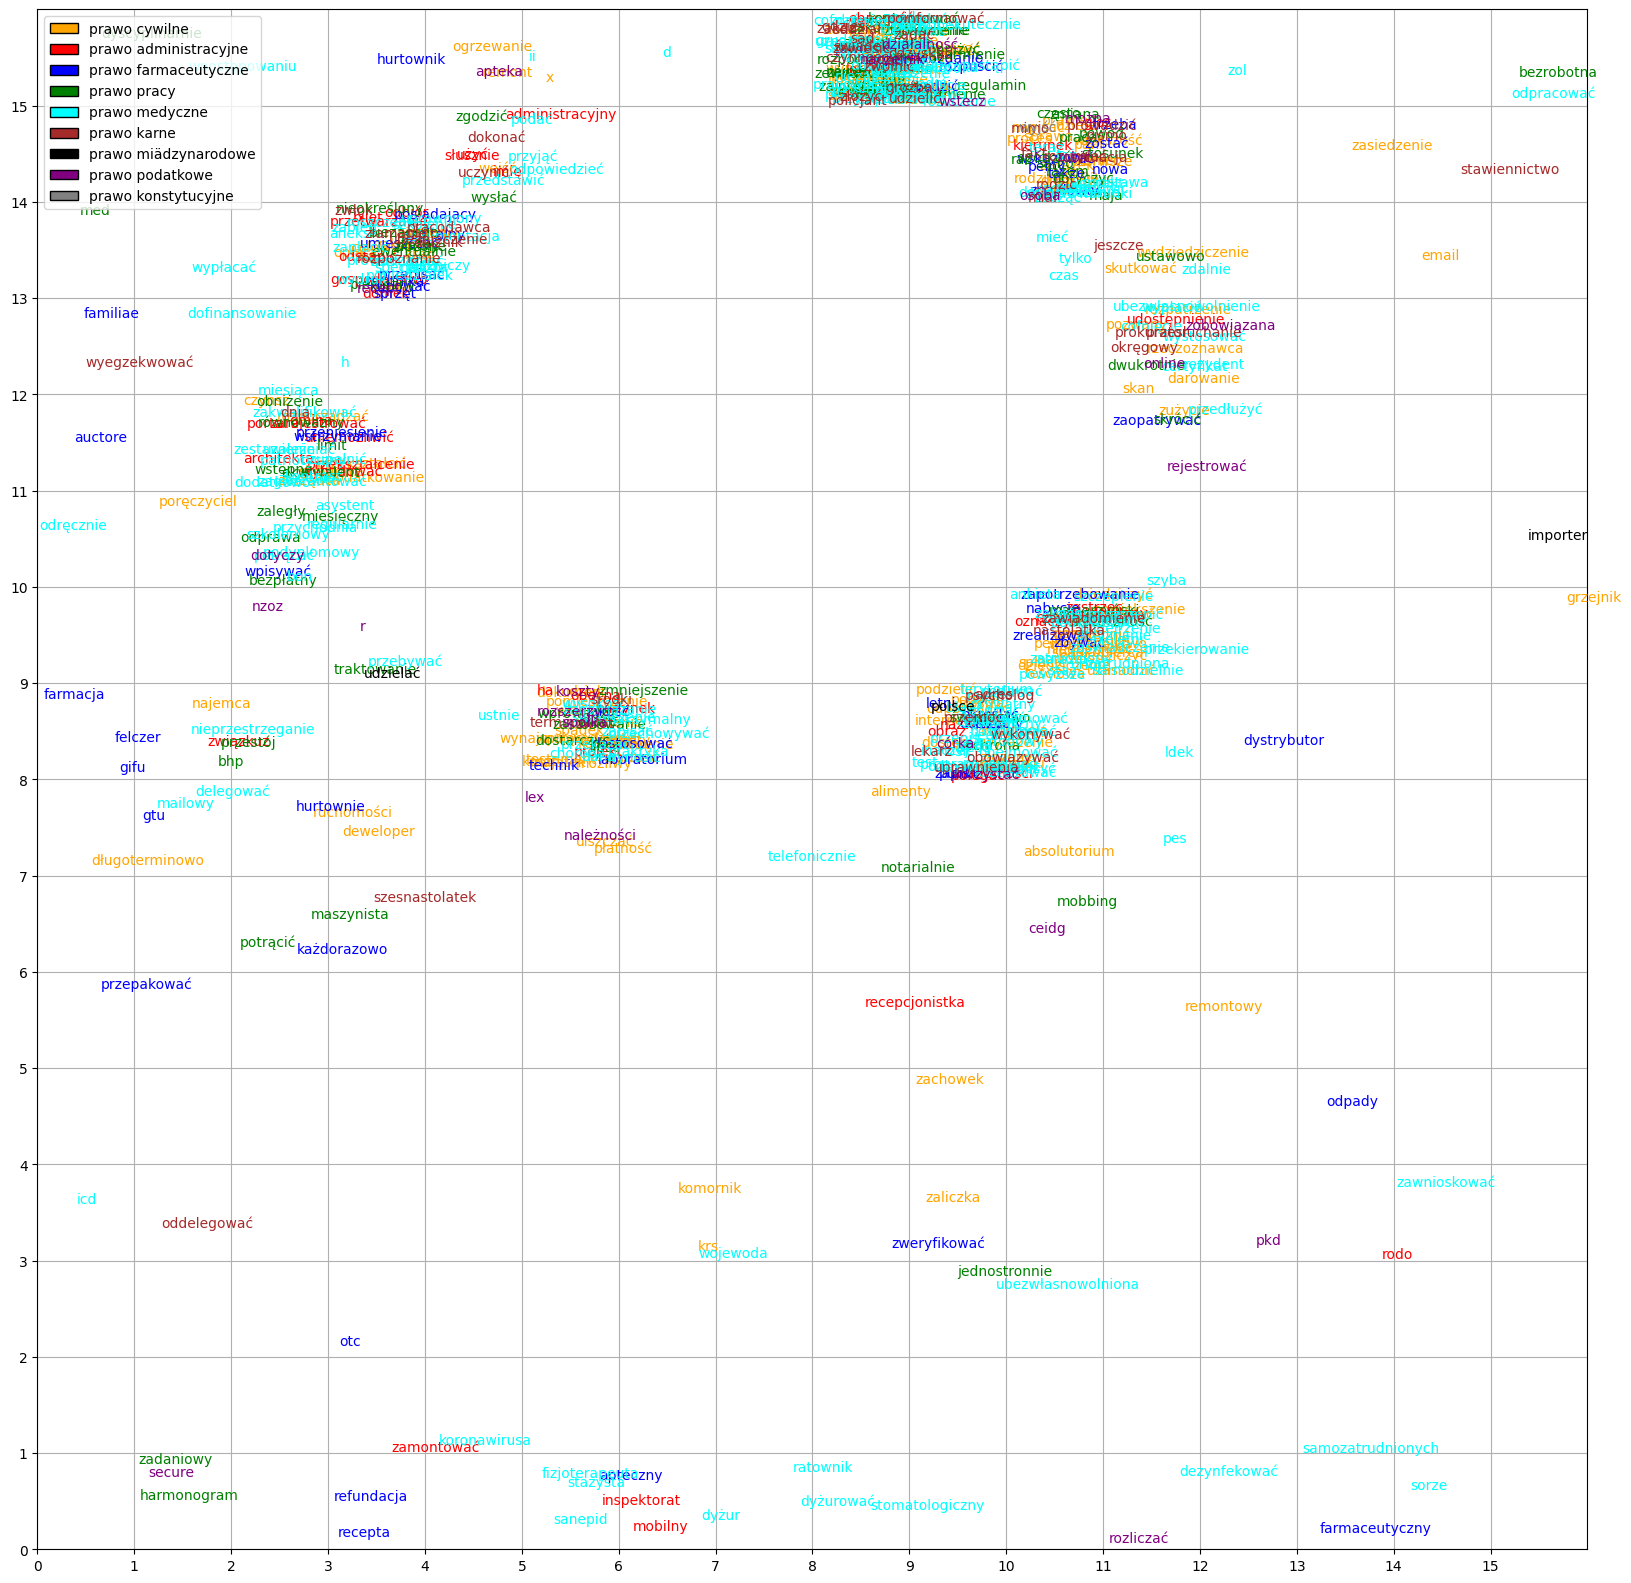

In [186]:
import ast
from matplotlib.patches import Patch
legend_elements = []
for index,color in enumerate(colors):
    c = list(colors.values())[index]
    l = list(colors.keys())[index]
    legend_elements.append(Patch(facecolor=c, edgecolor='black',label=l))
plt.figure(figsize=(20, 20))
texts = []
skippedWords = 0
allWords = 0
for index, affair in enumerate(data.keys()):
    words = ast.literal_eval(data[affair])
    words = clearListFromUselessWords(words)
    c = list(colors.values())[index]
    allWords += len(words)
    for word in words:
        try:
            vec = glove.get_vector(word)
            winnin_position = som.winner(vec)
            texts.append(plt.text((winnin_position[0]+np.random.rand()*.9)%map_dim, (winnin_position[1]+np.random.rand()*.9)%map_dim, word, color=c))
        except:
            skippedWords +=1
            
print("Did not find {}/{} words in the GloVe database, could not estimate their's vector".format(skippedWords,allWords))
plt.legend(handles=legend_elements, loc='upper left')
plt.xticks(range(map_dim))
plt.yticks(range(map_dim))
plt.grid()
plt.xlim([0, map_dim])
plt.ylim([0, map_dim])
plt.plot()